In [1]:
from implementation_functions import *

import pandas as pd
import numpy as np

from prince import FAMD #Factor analysis of mixed data
from aif360.metrics import BinaryLabelDatasetMetric
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import skfuzzy as fuzz

In [2]:
# SKIP THIS BLOCK IF YOU ARE ALREADY IMPORTING A DATAFRAME FROM A CSV(except sensitive attr and decision label definition)
data_name = "compas"
dataset_orig, privileged_groups, unprivileged_groups = aif_data(data_name, False)

In [3]:
#assign the sensitive attr and decision labels
sens_attr = ['race', 'sex']
decision_label = 'two_year_recid'
fav_l = 1
unfav_l = 0

In [4]:
# Initial disparities in the full original dataset
metric_orig = BinaryLabelDatasetMetric(dataset_orig, 
                                              unprivileged_groups=unprivileged_groups,
                                              privileged_groups=privileged_groups)
print("Disparate impact (of original labels) between unprivileged and privileged groups = %f" % metric_orig.disparate_impact())
print("Difference in statistical parity (of original labels) between unprivileged and privileged groups = %f" % metric_orig.statistical_parity_difference())
print("Individual fairness metric that measures how similar the labels are for similar instances = %f" % metric_orig.consistency())

c:\users\hatta\anaconda3\envs\aif360\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass n_neighbors=5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Disparate impact (of original labels) between unprivileged and privileged groups = 0.688041
Difference in statistical parity (of original labels) between unprivileged and privileged groups = -0.201474
Individual fairness metric that measures how similar the labels are for similar instances = 0.675213


In [5]:
# in this dataset, 'protected_attribute_maps': [sex={0.0: 'Male', 1.0: 'Female'}, 
# race={1.0: 'Caucasian', 0.0: 'Not Caucasian'}]
# class label maps': [{1.0: 'Did recid.', 0.0: 'No recid.'}]
orig_df, num_list, cat_list = preprocess(dataset_orig, sens_attr, decision_label)

In [6]:
#switch the dataset labels other way around for easier interpretation
orig_df['transf_labels'] = np.where(orig_df['two_year_recid']== 0, 1, 0)
decision_label = 'transf_labels'
orig_df = orig_df.drop('two_year_recid', axis=1)

orig_df, num_list, cat_list = preprocess(orig_df, sens_attr, decision_label)
orig_df['sub_labels'].value_counts()

0    1458
1    1166
3     968
2     652
5     346
7     310
4     203
6     170
Name: sub_labels, dtype: int64

In [7]:
#clean the columns that are not needed
cols = [c for c in orig_df.columns if (c.lower()[:13] != 'c_charge_desc')]
orig_df = orig_df[cols]
#Age information is duplicated in the dataset so delete one of them
cols2 = [c for c in orig_df.columns if (c.lower()[:7] != 'age_cat')]
orig_df = orig_df[cols2]

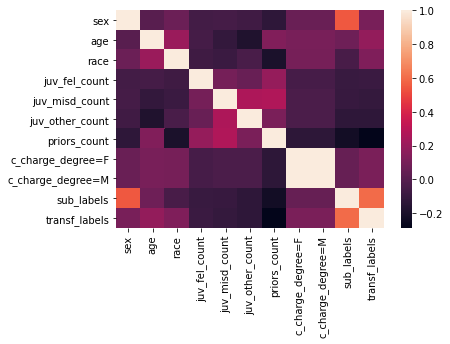

In [8]:
#check correlation of the columns
import seaborn as sns
res = orig_df.apply(lambda x : pd.factorize(x)[0] if (x.dtype == 'O') else x).corr(method='pearson', min_periods=1)
_ = sns.heatmap(res)

In [9]:
# Train-test split WITH stratification
X = orig_df.loc[:, orig_df.columns != decision_label]
y = orig_df.loc[:, orig_df.columns == decision_label].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, 
                                                    shuffle=True,
                                                    stratify=X['sub_labels'])

In [10]:
# Check class imbalance in the splitted training set
print(X_train['sub_labels'].value_counts())
print(X_test['sub_labels'].value_counts())

# Partial feture scaling (of numerical variables)
X_train, X_test = scale(X_train, X_test)
num_list, cat_list = type_lists(X_train)

0    1021
1     816
3     678
2     456
5     242
7     217
4     142
6     119
Name: sub_labels, dtype: int64
0    437
1    350
3    290
2    196
5    104
7     93
4     61
6     51
Name: sub_labels, dtype: int64


In [11]:
clf = RandomForestClassifier()
# Getting the baseline performance results from the imbalanced dataset
# Note: the function is created based on the assumption that the X's have sub_labels
# Instantiate the desired classifier obj to train the classification models    
baseline_stats, cm, ratio_table, preds = baseline_metrics(clf, X_train, X_test, 
                                                  y_train, y_test, sens_attr, 
                                                  fav_l, unfav_l)

In [12]:
print(baseline_stats)

                                                AEO Difference  \
[{'race': 0, 'sex': 0}][{'race': 1, 'sex': 0}]       -0.199713   
[{'race': 1, 'sex': 0}][{'race': 0, 'sex': 1}]       -0.111541   
[{'race': 0, 'sex': 1}][{'race': 1, 'sex': 1}]        0.093905   
[{'race': 0, 'sex': 0}][{'race': 0, 'sex': 1}]       -0.311254   
[{'race': 1, 'sex': 0}][{'race': 1, 'sex': 1}]       -0.017635   
[{'race': 0, 'sex': 0}][{'race': 1, 'sex': 1}]       -0.217348   

                                                Disparate Impact Ratio  \
[{'race': 0, 'sex': 0}][{'race': 1, 'sex': 0}]                0.625852   
[{'race': 1, 'sex': 0}][{'race': 0, 'sex': 1}]                0.833333   
[{'race': 0, 'sex': 1}][{'race': 1, 'sex': 1}]                1.160440   
[{'race': 0, 'sex': 0}][{'race': 0, 'sex': 1}]                0.521543   
[{'race': 1, 'sex': 0}][{'race': 1, 'sex': 1}]                0.967033   
[{'race': 0, 'sex': 0}][{'race': 1, 'sex': 1}]                0.605219   

                  

In [13]:
print(cm)

{'TP': 524.0, 'FP': 286.0, 'TN': 459.0, 'FN': 313.0}


In [14]:
print(ratio_table)

                       Base Ratio  Positive Ratio  Negative Ratio
Index                                                            
{'race': 0, 'sex': 0}    0.497472        0.190265        0.307206
{'race': 1, 'sex': 0}    0.307206        0.187737        0.119469
{'race': 0, 'sex': 1}    0.104298        0.076485        0.027813
{'race': 1, 'sex': 1}    0.091024        0.057522        0.033502


In [15]:
# Keep the subgroup labels to append them back later
keep_sub_l = X_train['sub_labels']

# Required drops for the GERMAN dataset (THIS DF CREATION IS A MUST)
X_train_new = X_train.drop(['race', 'sex', 'sub_labels'], axis=1)

# Get the idx of categ and numeric columns again due to the column drops above
num_list, cat_list = type_lists(X_train_new)

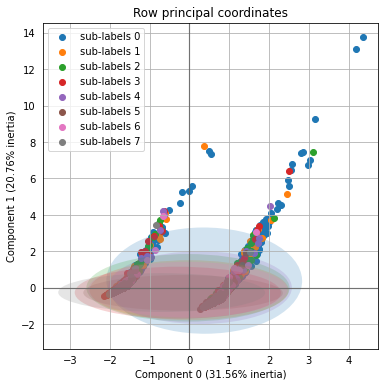

In [16]:
# Dimensionality reduction for big datasets with FAMD
X_train_new['sub_labels'] = keep_sub_l

famd = FAMD(n_components=2, random_state = 42)
famd.fit(X_train_new.drop('sub_labels', axis=1))
X_train_reduc = famd.transform(X_train_new)
#plotting the reduced dimensions
ax = famd.plot_row_coordinates(X_train_new, 
                                 color_labels=['sub-labels {}'.format(t) for t in X_train_new['sub_labels']])
# X_train_red = famd.partial_row_coordinates(X_train_new)
# famd.explained_inertia_
# ax = famd.plot_partial_row_coordinates(X_train_new, 
#                                         color_labels=['sub-labels {}'.format(t) for t in X_train_new['sub_labels']])
                               
# Delete the subgroup label column again if dimensionality reduction is used
X_train_new = X_train_new.drop(['sub_labels'], axis=1)

### Clustering Implementation with Fuzzy C-means

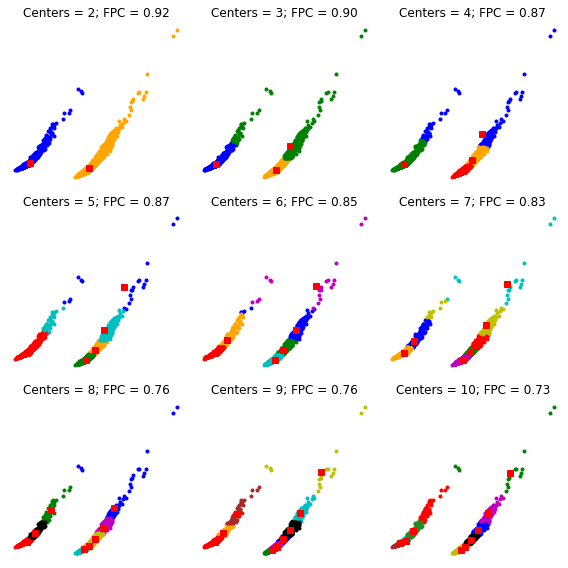

In [17]:
alldata = np.vstack((X_train_reduc[0], X_train_reduc[1]))
#Set up the loop and plot
colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']
fig1, axes1 = plt.subplots(3, 3, figsize=(8, 8))
fpcs = []

#checking for the optimal num of clusters with FPC plots
for ncenters, ax in enumerate(axes1.reshape(-1), 2):
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        alldata, ncenters, 2, error=0.005, maxiter=1000, init=None)

    # Store fpc values for later
    fpcs.append(fpc)

    # Plot assigned clusters, for each data point in training set
    cluster_membership = np.argmax(u, axis=0)
    for j in range(ncenters):
        ax.plot(X_train_reduc[0][cluster_membership == j],
                X_train_reduc[1][cluster_membership == j], '.', color=colors[j])

    # Mark the center of each fuzzy cluster
    for pt in cntr:
        ax.plot(pt[0], pt[1], 'rs')

    ax.set_title('Centers = {0}; FPC = {1:.2f}'.format(ncenters, fpc))
    ax.axis('off')
fig1.tight_layout()

Text(0, 0.5, 'Fuzzy partition coefficient')

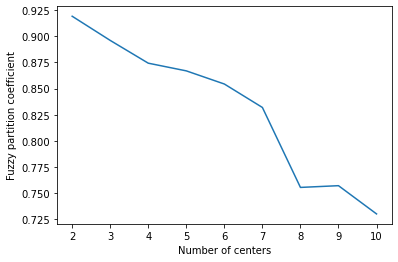

In [18]:
#fpc plot per number of clusters
fig2, ax2 = plt.subplots()
ax2.plot(np.r_[2:11], fpcs)
ax2.set_xlabel("Number of centers")
ax2.set_ylabel("Fuzzy partition coefficient")

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  2.74it/s]


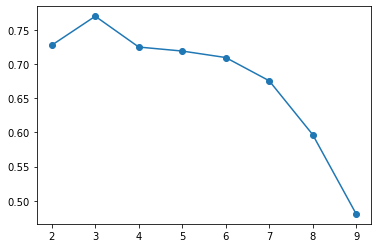

In [19]:
#silhouette score plot per number of cluster
from tqdm import tqdm
n_clusters = []
silhouette_scores = []
for i in tqdm(range(2, 10)):
    try:
        cntr, u_orig, _, _, _, _, _ = fuzz.cluster.cmeans(alldata, i, 2, error=0.005, 
                                                          maxiter=5000)
        u, u0, d, jm, p, fpc = fuzz.cluster.cmeans_predict(X_train_reduc.T, cntr, 2, error=0.005,       
                                                            maxiter=5000)
        clusters = np.argmax(u, axis=0)
        silhouette_val = silhouette_score(X_train_reduc, clusters, 
                                          metric='euclidean')
        silhouette_scores.append(silhouette_val)
        n_clusters.append(i)
    except:
        print(f"Can't cluster with {i} clusters")
plt.scatter(x=n_clusters, y=silhouette_scores)
plt.plot(n_clusters, silhouette_scores)
plt.show()

In [20]:
#either 4,5 or 6 clsuters
#predict with the num of clusters desired
n_clust = 5
cntr, u_orig, _, _, _, _, _ = fuzz.cluster.cmeans(alldata, n_clust, 2, error=0.005, 
                                                  maxiter=5000)
# u: final fuzzy-partitioned matrix, u0: initial guess at fuzzy c-partitioned matrix,
# d: final euclidean distance matrix, jm: obj func hist, p: num of iter run, 
#fpc: fuzzy partition coefficient
u, u0, d, jm, p, fpc = fuzz.cluster.cmeans_predict(X_train_reduc.T, cntr, 2, error=0.005,       
                                                   maxiter=5000)
clusters = np.argmax(u, axis=0)  # Hardening for silhouette   
print(silhouette_score(X_train_reduc, clusters, metric='cosine'))

0.8245884121519158


In [21]:
# Putting the required label info back to the dataframe before oversampling
X_train_new['cluster_labels'] = clusters
X_train_new['cluster_labels'] = X_train_new['cluster_labels'].astype('object')
X_train_new['sub_labels'] = keep_sub_l
# Also put the original decision labels so that they are also oversampled
X_train_new['class_labels'] = y_train

In [22]:
#cluster datasets in their original form
existing_clust = {}
for h in range(len(X_train_new['cluster_labels'].unique())):
   existing_clust[h] = X_train_new.loc[X_train_new['cluster_labels']==h]
#checking the subgroup counts in each cluster dataset
for item in existing_clust:
    print(existing_clust[item]['sub_labels'].value_counts())

#fixing the cluster memberships in each df if a sample from a subgroup is alone
fixed_clusters = fix_memberships_fcm(X_train_new, X_train_reduc, clust_centroids=cntr)
#checking the subgroup counts in each cluster dataset
for item in fixed_clusters:
    print(fixed_clusters[item]['sub_labels'].value_counts())

3    265
1    253
0    200
2    142
7    119
5     90
6     38
4     31
Name: sub_labels, dtype: int64
0    84
1    16
2     9
4     5
3     4
7     1
6     1
5     1
Name: sub_labels, dtype: int64
0    261
1     85
2     63
3     33
4     17
5     15
6     11
7      4
Name: sub_labels, dtype: int64
1    444
0    416
3    363
2    220
5    135
7     89
4     83
6     65
Name: sub_labels, dtype: int64
0    60
2    22
1    18
3    13
4     6
7     4
6     4
5     1
Name: sub_labels, dtype: int64
3    265
1    253
0    200
2    142
7    119
5     91
6     38
4     31
Name: sub_labels, dtype: int64
0    84
1    16
2     9
4     5
3     4
Name: sub_labels, dtype: int64
0    261
1     85
2     63
3     33
4     17
5     16
6     12
7      5
Name: sub_labels, dtype: int64
1    444
0    416
3    363
2    220
5    135
7     89
4     83
6     65
Name: sub_labels, dtype: int64
0    60
2    22
1    18
3    13
4     6
7     4
6     4
Name: sub_labels, dtype: int64


In [23]:
#transform the data types of all the columns to numeric for SMOTE
for df in fixed_clusters:
    for i in range(len(fixed_clusters[df].columns)):       
        fixed_clusters[df].iloc[:,i] = fixed_clusters[df].iloc[:,i].astype('float')

# Over-sampling of each cluster
oversampled_clusters, unique_subl = oversample(fixed_clusters)
for item in oversampled_clusters:
    print(oversampled_clusters[item]['sub_labels'].value_counts())

# Deleting sensitive attributes and subgroup labels from test set is required
# to apply the implemented solutions (sens. attr. are not used to satisfy the
# disparate treatment in the functions)
test_sublabels = X_test['sub_labels']
X_test_n = X_test.drop(['race', 'sex','sub_labels'], axis=1)
num_list, cat_list = type_lists(X_test_n)
X_test_reduc = famd.transform(X_test_n)

7    265
5    265
3    265
1    265
6    265
4    265
2    265
0    265
Name: sub_labels, dtype: int64
4    84
3    84
2    84
1    84
0    84
Name: sub_labels, dtype: int64
7    261
5    261
3    261
1    261
6    261
4    261
2    261
0    261
Name: sub_labels, dtype: int64
7    444
5    444
3    444
1    444
6    444
4    444
2    444
0    444
Name: sub_labels, dtype: int64
7    60
6    60
4    60
3    60
2    60
1    60
0    60
Name: sub_labels, dtype: int64


### CLASS LABEL PREDICTIONS PER STRATEGY

In [24]:
# Predicting the test sets based on strategy 1
X_test_pred1 = predict_whole_set(clf, oversampled_clusters, X_test_n)

# Predicting the test sets based on strategy 2   
#t_u is needed later for option 3
t_u, u0, d, jm, p, fpc = fuzz.cluster.cmeans_predict(
    X_test_reduc.T, cntr, 2, error=0.005, maxiter=1000)
test_clusts = np.argmax(t_u, axis=0) 
X_test_pred2 = predict_w_fuzzy(clf, oversampled_clusters, X_test_n, 
                               X_test_reduc, cntr, unique_subl, test_sublabels)

# Predicting the test sets based on strategy 3
X_test_pred3 = predict_w_weights_fuzzy(clf, oversampled_clusters, t_u, 
                                       X_test_n, unique_subl, test_sublabels)

#### The metrics table creation for given dataset: Protected attributes and groups must be defined based on the dataset and preferences to calculate fairness and performance metrics

In [25]:
metrics_table1, cm1, ratio_t1 = metrics_calculate(X_test, X_test_pred1, y_test,
                                                  sens_attr, fav_l, unfav_l)
metrics_table2, cm2, ratio_t2 = metrics_calculate(X_test, X_test_pred2, y_test,
                                                  sens_attr, fav_l, unfav_l)
metrics_table3, cm3, ratio_t3 = metrics_calculate(X_test, X_test_pred3, y_test,
                                                  sens_attr, fav_l, unfav_l)

In [26]:
#outputs from strategy 1
print(metrics_table1)
print("Confusion Matrix:", cm1)
print(ratio_t1)

                                                AEO Difference  \
[{'race': 0, 'sex': 0}][{'race': 1, 'sex': 0}]       -0.136378   
[{'race': 1, 'sex': 0}][{'race': 0, 'sex': 1}]        0.033217   
[{'race': 0, 'sex': 1}][{'race': 1, 'sex': 1}]       -0.076065   
[{'race': 0, 'sex': 0}][{'race': 0, 'sex': 1}]       -0.103162   
[{'race': 1, 'sex': 0}][{'race': 1, 'sex': 1}]       -0.042848   
[{'race': 0, 'sex': 0}][{'race': 1, 'sex': 1}]       -0.179226   

                                                Disparate Impact Ratio  \
[{'race': 0, 'sex': 0}][{'race': 1, 'sex': 0}]                0.750844   
[{'race': 1, 'sex': 0}][{'race': 0, 'sex': 1}]                1.028312   
[{'race': 0, 'sex': 1}][{'race': 1, 'sex': 1}]                0.881200   
[{'race': 0, 'sex': 0}][{'race': 0, 'sex': 1}]                0.772102   
[{'race': 1, 'sex': 0}][{'race': 1, 'sex': 1}]                0.906149   
[{'race': 0, 'sex': 0}][{'race': 1, 'sex': 1}]                0.680377   

                  

In [27]:
#outputs from strategy 2
print(metrics_table2)
print("Confusion Matrix:", cm2)
print(ratio_t2)

                                                AEO Difference  \
[{'race': 0, 'sex': 0}][{'race': 1, 'sex': 0}]       -0.122754   
[{'race': 1, 'sex': 0}][{'race': 0, 'sex': 1}]        0.012757   
[{'race': 0, 'sex': 1}][{'race': 1, 'sex': 1}]       -0.051252   
[{'race': 0, 'sex': 0}][{'race': 0, 'sex': 1}]       -0.109997   
[{'race': 1, 'sex': 0}][{'race': 1, 'sex': 1}]       -0.038495   
[{'race': 0, 'sex': 0}][{'race': 1, 'sex': 1}]       -0.161249   

                                                Disparate Impact Ratio  \
[{'race': 0, 'sex': 0}][{'race': 1, 'sex': 0}]                0.761894   
[{'race': 1, 'sex': 0}][{'race': 0, 'sex': 1}]                0.977270   
[{'race': 0, 'sex': 1}][{'race': 1, 'sex': 1}]                0.933818   
[{'race': 0, 'sex': 0}][{'race': 0, 'sex': 1}]                0.744576   
[{'race': 1, 'sex': 0}][{'race': 1, 'sex': 1}]                0.912593   
[{'race': 0, 'sex': 0}][{'race': 1, 'sex': 1}]                0.695299   

                  

In [28]:
#outputs from strategy 3
print(metrics_table3)
print("Confusion Matrix:", cm3)
print(ratio_t3)

                                                AEO Difference  \
[{'race': 0, 'sex': 0}][{'race': 1, 'sex': 0}]       -0.137406   
[{'race': 1, 'sex': 0}][{'race': 0, 'sex': 1}]        0.038363   
[{'race': 0, 'sex': 1}][{'race': 1, 'sex': 1}]       -0.084245   
[{'race': 0, 'sex': 0}][{'race': 0, 'sex': 1}]       -0.099043   
[{'race': 1, 'sex': 0}][{'race': 1, 'sex': 1}]       -0.045881   
[{'race': 0, 'sex': 0}][{'race': 1, 'sex': 1}]       -0.183288   

                                                Disparate Impact Ratio  \
[{'race': 0, 'sex': 0}][{'race': 1, 'sex': 0}]                0.739858   
[{'race': 1, 'sex': 0}][{'race': 0, 'sex': 1}]                1.021783   
[{'race': 0, 'sex': 1}][{'race': 1, 'sex': 1}]                0.889840   
[{'race': 0, 'sex': 0}][{'race': 0, 'sex': 1}]                0.755974   
[{'race': 1, 'sex': 0}][{'race': 1, 'sex': 1}]                0.909223   
[{'race': 0, 'sex': 0}][{'race': 1, 'sex': 1}]                0.672696   

                  